## US Innovation: Patent Event Studies and Panel Regressions

Objective: evaluate the causal effect of high-tech US military procurement spending on the formation of regional innovative clusters. If focus specifically on the surge in spending that occured from 1981-1985 during Reagan's first term in office.

Datasets:
1) Universe of US patents 
2) All procurment contracts by the US Department of Defence (DoD) 1966-2003
3) County-level descriptive variables from a range of sources

I construct a county-year panel from 1966-2003 where:
- X_it = total DoD procurement dollars spent in county i in year t
- Y_it = citation weighted number of patents in county i in year t

Approach:

1) To provide motivating evidence that there is an effect I perform a Difference-in-Difference design comparing the trajectory of patenting between the counties which recieved the largest surge in spending compared to the rest which received less.

2) Approach (1) suffers from the fact that there are factors, such as the presence of universities, which correlate with how much increased funding the county got under Reagan and also effect the growth in patenting over time. To overcome this problem I use an IV approach where the exogeneity of the instrument comes from the exogenous changes in spending of the DoD in specific technological product categories (to read more on the methodology refer to the paper found in folder XXX).

## Imports and Shared Helpers

Load the libraries used across the analyses and define a project-level data path.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jinja2

plt.style.use('ggplot')

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'


## 1. Difference-in-Differences Event Study

Replicate the Stata event-study by recreating the treatment definition and plotting the average citation-weighted patent counts for treated and control counties.

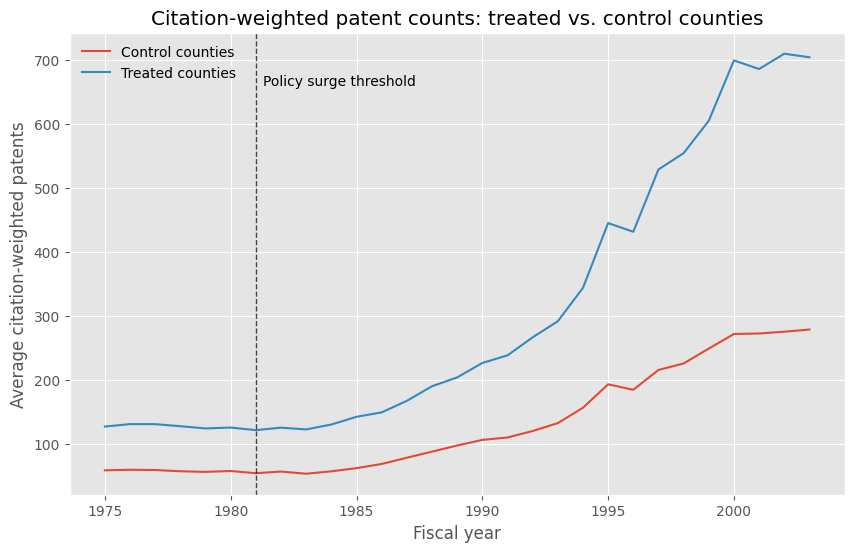

,fyear,treated,w_cites_sub
0,1975.0,0,59.485298
1,1975.0,1,127.820600
2,1976.0,0,60.387803
3,1976.0,1,131.583262
4,1977.0,0,59.963162


In [3]:
# Load the panel used in the event-study specification
panel = pd.read_stata(DATA_DIR / 'built.dta')
defcon = pd.read_stata(DATA_DIR / 'defcon_patent_merge_county_year_final.dta')
panel = panel.merge(defcon, on=['county_fips', 'fyear'], how='inner', suffixes=('', '_defcon'))

# Match the Stata data restrictions
panel = panel[(panel['fyear'] >= 1965) & (panel['fyear'] <= 2003)].copy()
if 'county_id' in panel.columns:
    panel = panel.drop(columns=['county_id'])
panel = panel.drop(columns=[c for c in panel.columns if c.endswith('_defcon')], errors='ignore')
panel['semi_intens'] = panel.groupby('county_fips')['semi_intens'].transform('max')
panel = panel[panel['semi_intens'] == 1].copy()

# Compute the pre- and post-surge procurement averages by county
pre_window = panel['fyear'].between(1976, 1981)
post_window = panel['fyear'].between(1981, 1989)
pre_spend = panel.loc[pre_window].groupby('county_fips')['total_dollars'].mean()
post_spend = panel.loc[post_window].groupby('county_fips')['total_dollars'].mean()
panel = panel.join(pre_spend.rename('mean_spend_pre'), on='county_fips')
panel = panel.join(post_spend.rename('mean_spend_post'), on='county_fips')
panel['surge'] = panel['mean_spend_post'] - panel['mean_spend_pre']
surge_cutoff = panel.drop_duplicates('county_fips')['surge'].median()
panel['treated'] = (panel['surge'] > surge_cutoff).astype(int)

panel['after'] = (panel['fyear'] > 1981).astype(int)
panel['treatment'] = panel['after'] * panel['treated']

# Summarise mean outcomes by treatment status and year
event_study = (
    panel.dropna(subset=['w_cites_sub'])
         .groupby(['fyear', 'treated'])['w_cites_sub']
         .mean()
         .reset_index()
)

# Make the trend plot
fig, ax = plt.subplots(figsize=(10, 6))
labels = {0: 'Control counties', 1: 'Treated counties'}
for treated, group in event_study.groupby('treated'):
    ax.plot(group['fyear'], group['w_cites_sub'], label=labels[treated])

policy_year = 1981
ax.axvline(policy_year, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.set_title('Citation-weighted patent counts: treated vs. control counties')
ax.set_xlabel('Fiscal year')
ax.set_ylabel('Average citation-weighted patents')
ax.legend(frameon=False)
ax.annotate('Policy surge threshold', xy=(policy_year, ax.get_ylim()[1]), xytext=(5, -30), textcoords='offset points', ha='left', va='top', fontsize=10)
plt.show()

event_study.head()


The figure now mirrors the Stata `estat trendplot` output because the notebook replicates the same merge, sample restrictions, and treatment definition before plotting the treated and control means.

## 2. Instrumental Variables Panel Regression

Recreate the two-way fixed-effects IV specification from `panel_regressions_6675.do` using NumPy, including clustered standard errors and a presentation-ready coefficient table.

In [7]:
from IPython.display import display
import importlib.util

def residualize_fixed_effects(frame: pd.DataFrame, columns, fixed_effects, max_iter: int = 100, tol: float = 1e-8):
    """Residualise columns by removing the listed fixed effects via alternating projections."""
    residuals = frame[columns].astype(float).copy()
    if not fixed_effects:
        return residuals
    for _ in range(max_iter):
        previous = residuals.to_numpy(copy=True)
        for fe in fixed_effects:
            means = residuals.groupby(frame[fe])[columns].transform('mean')
            residuals -= means
        if np.max(np.abs(residuals.to_numpy() - previous)) < tol:
            break
    return residuals


def cluster_robust_vcov(X: np.ndarray, residuals: np.ndarray, clusters: np.ndarray) -> np.ndarray:
    """One-way (county) cluster-robust covariance estimator."""
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    cov = np.zeros((X.shape[1], X.shape[1]))
    clusters = np.asarray(clusters)
    for group_id in np.unique(clusters):
        mask = clusters == group_id
        X_g = X[mask]
        u_g = residuals[mask][:, None]
        cov += X_g.T @ (u_g @ u_g.T) @ X_g
    return XtX_inv @ cov @ XtX_inv


def fit_ols(y: np.ndarray, endog: np.ndarray, controls: np.ndarray, clusters: np.ndarray):
    if controls.size:
        X = np.column_stack([endog, controls])
    else:
        X = endog[:, None]
    beta = np.linalg.solve(X.T @ X, X.T @ y)
    residuals = y - X @ beta
    vcov = cluster_robust_vcov(X, residuals, clusters)
    se = np.sqrt(np.diag(vcov))
    tss = ((y - y.mean()) ** 2).sum()
    rss = (residuals ** 2).sum()
    r_squared = 1 - rss / tss if tss > 0 else np.nan
    return beta, se, r_squared


def fit_2sls(y: np.ndarray, endog: np.ndarray, instrument: np.ndarray, controls: np.ndarray, clusters: np.ndarray):
    if controls.size:
        X = np.column_stack([endog, controls])
        Z = np.column_stack([instrument, controls])
    else:
        X = endog[:, None]
        Z = instrument[:, None]

    ZZ_inv = np.linalg.inv(Z.T @ Z)
    XTZ = X.T @ Z
    beta = np.linalg.solve(XTZ @ ZZ_inv @ XTZ.T, XTZ @ ZZ_inv @ Z.T @ y)
    residuals = y - X @ beta

    cov = np.zeros_like(XTZ @ ZZ_inv @ XTZ.T)
    clusters = np.asarray(clusters)
    for group_id in np.unique(clusters):
        mask = clusters == group_id
        X_g = X[mask]
        Z_g = Z[mask]
        u_g = residuals[mask][:, None]
        cov += X_g.T @ Z_g @ ZZ_inv @ Z_g.T @ (u_g @ u_g.T) @ Z_g @ ZZ_inv @ Z_g.T @ X_g

    bread = np.linalg.inv(XTZ @ ZZ_inv @ XTZ.T)
    vcov = bread @ cov @ bread
    se = np.sqrt(np.diag(vcov))

    first_stage_coef = np.linalg.solve(Z.T @ Z, Z.T @ endog)
    first_stage_resid = endog - Z @ first_stage_coef
    first_stage_vcov = cluster_robust_vcov(Z, first_stage_resid, clusters)
    first_stage_se = np.sqrt(np.diag(first_stage_vcov))
    first_stage_F = float((first_stage_coef[0] / first_stage_se[0]) ** 2) if first_stage_se[0] != 0 else np.nan

    return beta, se, first_stage_F


# Load and tidy the panel used for the IV specifications
iv_panel = pd.read_stata(DATA_DIR / 'built5.dta')
iv_panel = iv_panel[(iv_panel['semi_intens'] == 1) & (iv_panel['fyear'] > 1975)].copy()
iv_panel['fyear'] = iv_panel['fyear'].astype(int)
iv_panel['state_year'] = iv_panel['state'].astype(str).str.strip() + '_' + iv_panel['fyear'].astype(str)

specifications = [
    {
        'label': 'Baseline FE',
        'controls': [],
        'fixed_effects': ['county_fips', 'fyear'],
    },
    {
        'label': 'Add controls',
        'controls': ['avg_wages', 'pop', 'emp'],
        'fixed_effects': ['county_fips', 'fyear'],
    },
    {
        'label': 'Add state-year FE',
        'controls': ['avg_wages', 'pop', 'emp'],
        'fixed_effects': ['county_fips', 'fyear', 'state_year'],
    },
]

results = []

for spec in specifications:
    columns = ['lw_cites_sub', 'ltotal_dollars', 'log_spending_6675_iv'] + spec['controls']
    required = columns + spec['fixed_effects'] + ['county_fips']
    subset = iv_panel.dropna(subset=required).copy()
    residuals = residualize_fixed_effects(subset, columns, spec['fixed_effects'])

    y = residuals['lw_cites_sub'].to_numpy()
    endog = residuals['ltotal_dollars'].to_numpy()
    instrument = residuals['log_spending_6675_iv'].to_numpy()
    controls = residuals[spec['controls']].to_numpy() if spec['controls'] else np.empty((len(subset), 0))
    clusters = subset['county_fips'].astype(int).to_numpy()

    ols_beta, ols_se, ols_r2 = fit_ols(y, endog, controls, clusters)
    iv_beta, iv_se, first_stage_F = fit_2sls(y, endog, instrument, controls, clusters)

    regressor_names = ['ltotal_dollars'] + spec['controls']
    results.append({
        'label': spec['label'],
        'controls': spec['controls'],
        'regressor_names': regressor_names,
        'ols_beta': ols_beta,
        'ols_se': ols_se,
        'ols_r2': ols_r2,
        'iv_beta': iv_beta,
        'iv_se': iv_se,
        'first_stage_F': first_stage_F,
        'observations': len(subset),
        'clusters': subset['county_fips'].nunique(),
    })


def pretty_entry(beta: float, se: float) -> str:
    def _fmt(value: float) -> str:
        if np.isnan(value):
            return 'nan'
        abs_value = abs(value)
        if abs_value >= 0.01:
            return f'{value:,.2f}'
        elif abs_value >= 0.001:
            return f'{value:,.3f}'
        else:
            return f'{value:.2e}'
    return f"{_fmt(beta)}
({_fmt(se)})"


column_labels = []
for spec in results:
    column_labels.extend([
        (spec['label'], 'OLS'),
        (spec['label'], 'IV'),
    ])
columns = pd.MultiIndex.from_tuples(column_labels, names=['Specification', 'Estimator'])

variable_mapping = [
    ('Log procurement', 'ltotal_dollars'),
    ('Average wages', 'avg_wages'),
    ('Population', 'pop'),
    ('Employment', 'emp'),
]

table_rows = []
index_labels = []

for label, var in variable_mapping:
    row = []
    for spec in results:
        index_map = {name: idx for idx, name in enumerate(spec['regressor_names'])}
        if var in index_map:
            idx = index_map[var]
            row.append(pretty_entry(spec['ols_beta'][idx], spec['ols_se'][idx]))
            row.append(pretty_entry(spec['iv_beta'][idx], spec['iv_se'][idx]))
        else:
            row.extend(['--', '--'])
    table_rows.append(row)
    index_labels.append(label)

for summary_label, value_fn in [
    ('Observations', lambda spec: f"{spec['observations']:,}"),
    ('Clusters (county)', lambda spec: f"{spec['clusters']:,}"),
]:
    row = []
    for spec in results:
        value = value_fn(spec)
        row.extend([value, value])
    table_rows.append(row)
    index_labels.append(summary_label)

row = []
for spec in results:
    r2 = spec['ols_r2']
    display_value = f'{r2:.3f}' if not np.isnan(r2) else 'nan'
    row.append(display_value)
    row.append('--')
table_rows.append(row)
index_labels.append('Within R-squared')

row = []
for spec in results:
    row.append('--')
    row.append(f"{spec['first_stage_F']:.2f}" if not np.isnan(spec['first_stage_F']) else 'nan')
table_rows.append(row)
index_labels.append('First-stage F')

results_table = pd.DataFrame(table_rows, index=index_labels, columns=columns)


if importlib.util.find_spec('jinja2') is not None:
    table_to_show = (
        results_table.style
            .set_properties(**{'text-align': 'center', 'font-family': 'serif'})
            .set_table_styles([
                {'selector': 'th', 'props': [('text-align', 'center'), ('font-family', 'serif')]},
                {'selector': 'td', 'props': [('padding', '6px 12px')]},
            ])
    )
else:
    table_to_show = results_table

display(table_to_show)


SyntaxError: EOL while scanning string literal (2302782351.py, line 151)

The table alternates OLS and IV columns across progressively richer specifications. Columns (1) and (2) use county and year fixed effects only, columns (3) and (4) add wage, population, and employment controls, and columns (5) and (6) further include state-by-year fixed effects. All models are estimated on the semi-intensive county sample, report county-clustered standard errors, and show the IV first-stage F statistic for instrument strength.